# Группировка данных и оконные функции #

## 1. Создать таблицы со следующими структурами и загрузить данные из csv-файлов ##

### DDL-скрипт ###
<code>
create schema if not exists hw_3;

create table if not exists hw_3.customer (
  customer_id serial primary key,
  first_name varchar(50) not null,
  last_name varchar(50),
  gender varchar(30) not null,
  dob varchar(50),
  job_title varchar(50),
  job_industry_category varchar(50) not null,
  wealth_segment varchar(50) not null,
  deceased_indicator varchar(50) not null,
  owns_car varchar(30) not null,
  address varchar(50) not null,
  postcode varchar(30) not null,
  state varchar(30) not null,
  country varchar(30) not null,
  property_valuation int4 not null
);

create table if not exists hw_3.transaction (
  transaction_id serial primary key,
  product_id int4 not null,
  customer_id int4 not null,
  transaction_date varchar(30) not null,
  online_order varchar(30),
  order_status varchar(30) not null,
  brand varchar(30),
  product_line varchar(30),
  product_class varchar(30),
  product_size varchar(30),
  list_price float4 not null,
  standard_cost float4
  -- constraint fk_transaction_customer_id FOREIGN KEY (customer_id) REFERENCES hw_3.customer(customer_id)
);
</code>

- *В условиях задачи не указано создание FK в таблице с транзакциями на таблицу с клиентами. Чтобы загрузить все данные из таблиц Excel, закомментировал строку с FK.*
- *Данные с предыдущего домашнего задания не изменялись.*

### Результат выполнения ###
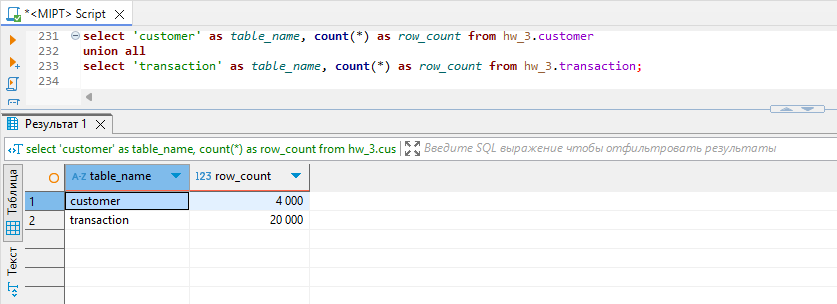

## 2. Выполнить следующие запросы ##

### 2.1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества ###
#### Скрипт ####
<code>
select c.job_industry_category, count(*) as customer_cnt
from hw_3.customer c
group by c.job_industry_category
order by customer_cnt desc;
</code>

- *Не стал убирать значения с "n/a" в сфере деятельности, т.к. не было такого требования.*

#### Результат выполнения ####
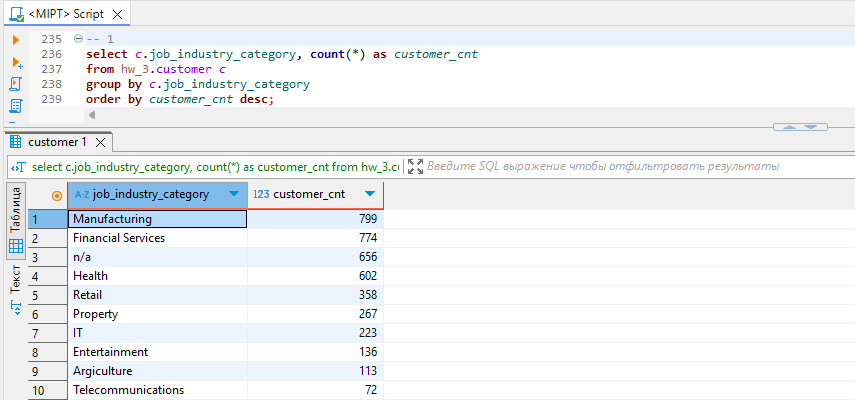

### 2.2. Найти сумму транзакций за каждый месяц по сферам деятельности, отсортировав по месяцам и по сфере деятельности ###
#### Скрипт ####
<code>
select
    c.job_industry_category
    ,date_trunc('month', to_date(t.transaction_date, 'DD.MM.YYYY')) as transaction_month
    ,sum(t.list_price) as transaction_sum
from hw_3.transaction t
join hw_3.customer c on c.customer_id = t.customer_id
group by c.job_industry_category, transaction_month
order by c.job_industry_category, transaction_month;
</code>

#### Результат выполнения ####
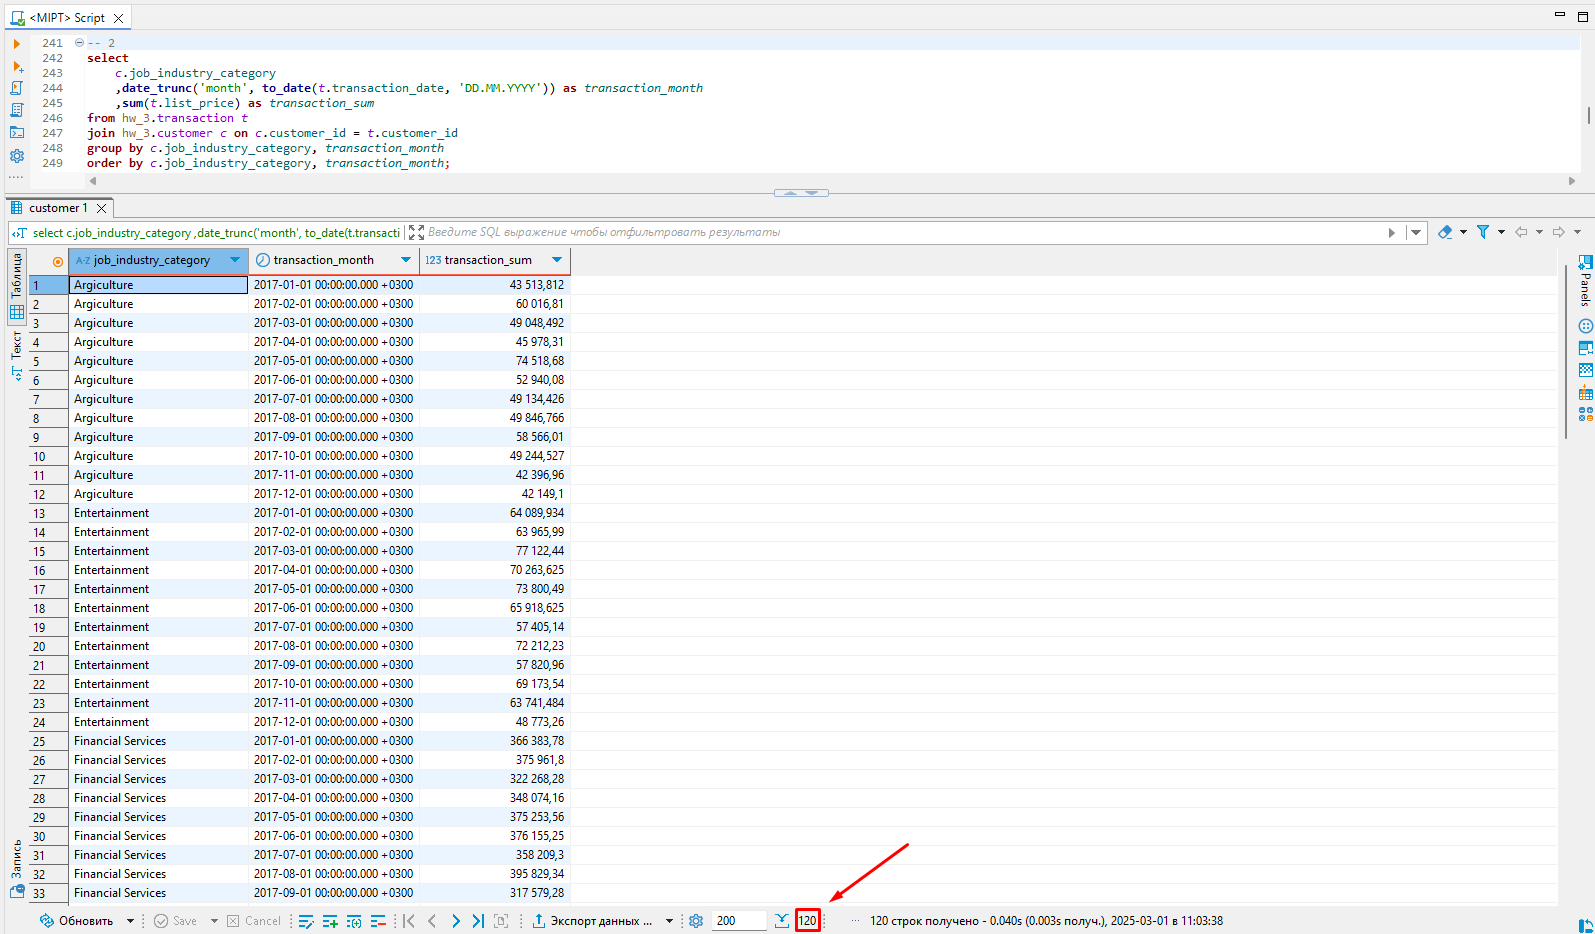

### 2.3. Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT ###
#### Скрипт ####
<code>
select
    t.brand
    ,count(*) as order_count
from hw_3.transaction t
join hw_3.customer c on c.customer_id = t.customer_id
    and lower(c.job_industry_category) = 'it'
where lower(t.online_order) = 'true'
    and lower(t.order_status) = 'approved'
    and coalesce(t.brand,'') != ''
group by t.brand
order by t.brand;
</code>

#### Результат выполнения ####
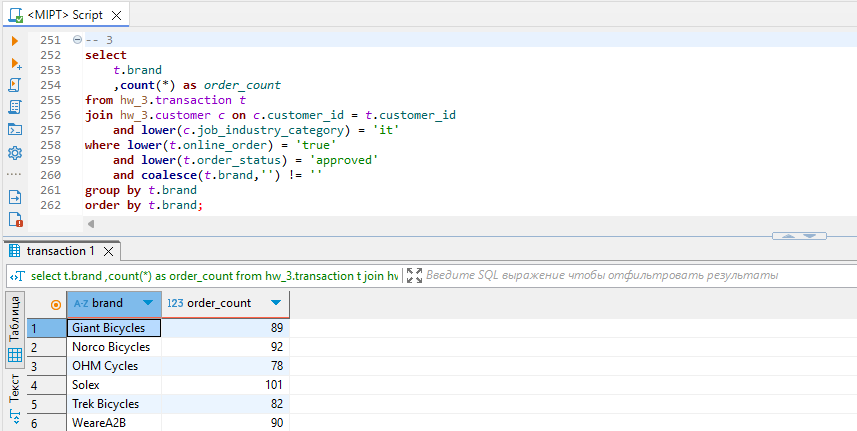

### 2.4. Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, отсортировав результат по убыванию суммы транзакций и количества клиентов. Выполните двумя способами: используя только group by и используя только оконные функции. Сравните результат ###
#### Скрипт ####
##### GROUP BY #####
<code>
select
    t.customer_id
    ,sum(t.list_price) as transaction_sum
    ,max(t.list_price) as transaction_max
    ,min(t.list_price) as transaction_min
    ,count(t.transaction_id) as transaction_count
from hw_3.transaction t
group by t.customer_id
order by transaction_sum desc, transaction_count desc;
</code>

- *Возможно, в задании находится опечатка и необходимо отсортировать результат по убыванию суммы транзакций и количества транзакций, а не клиентов.*

##### Оконные функции #####
<code>
select distinct
    t.customer_id
    ,sum(t.list_price) over (partition by t.customer_id) as transaction_sum
    ,max(t.list_price) over (partition by t.customer_id) as transaction_max
    ,min(t.list_price) over (partition by t.customer_id) as transaction_min
    ,count(t.transaction_id) over (partition by t.customer_id) as transaction_count
from hw_3.transaction t
order by transaction_sum desc, transaction_count desc;
</code>

#### Результат выполнения ####
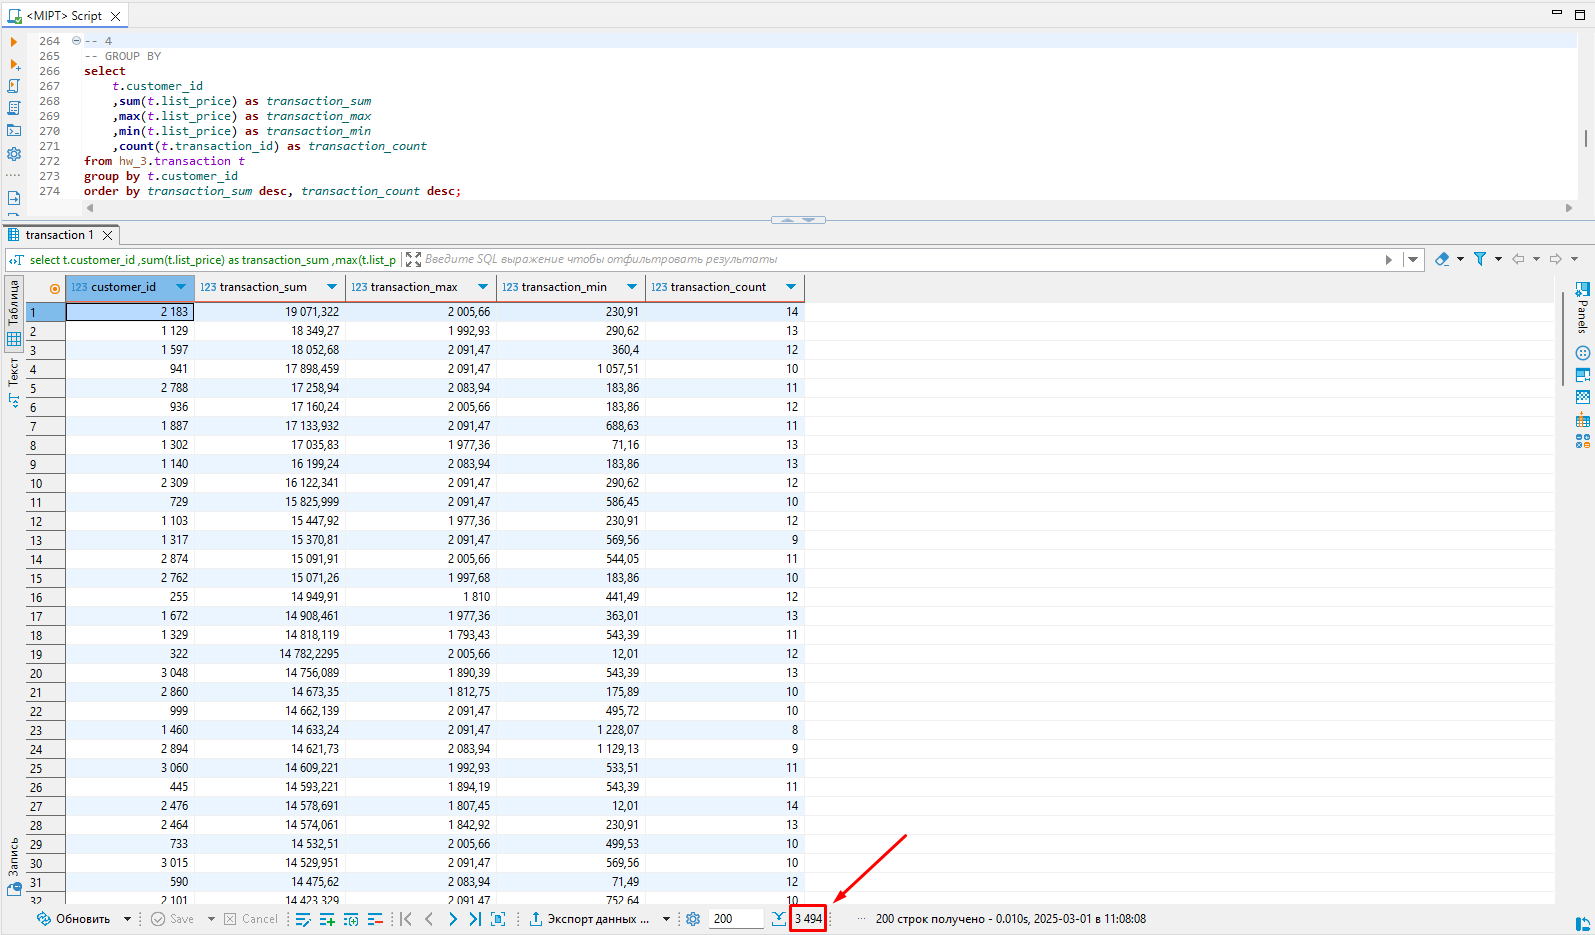
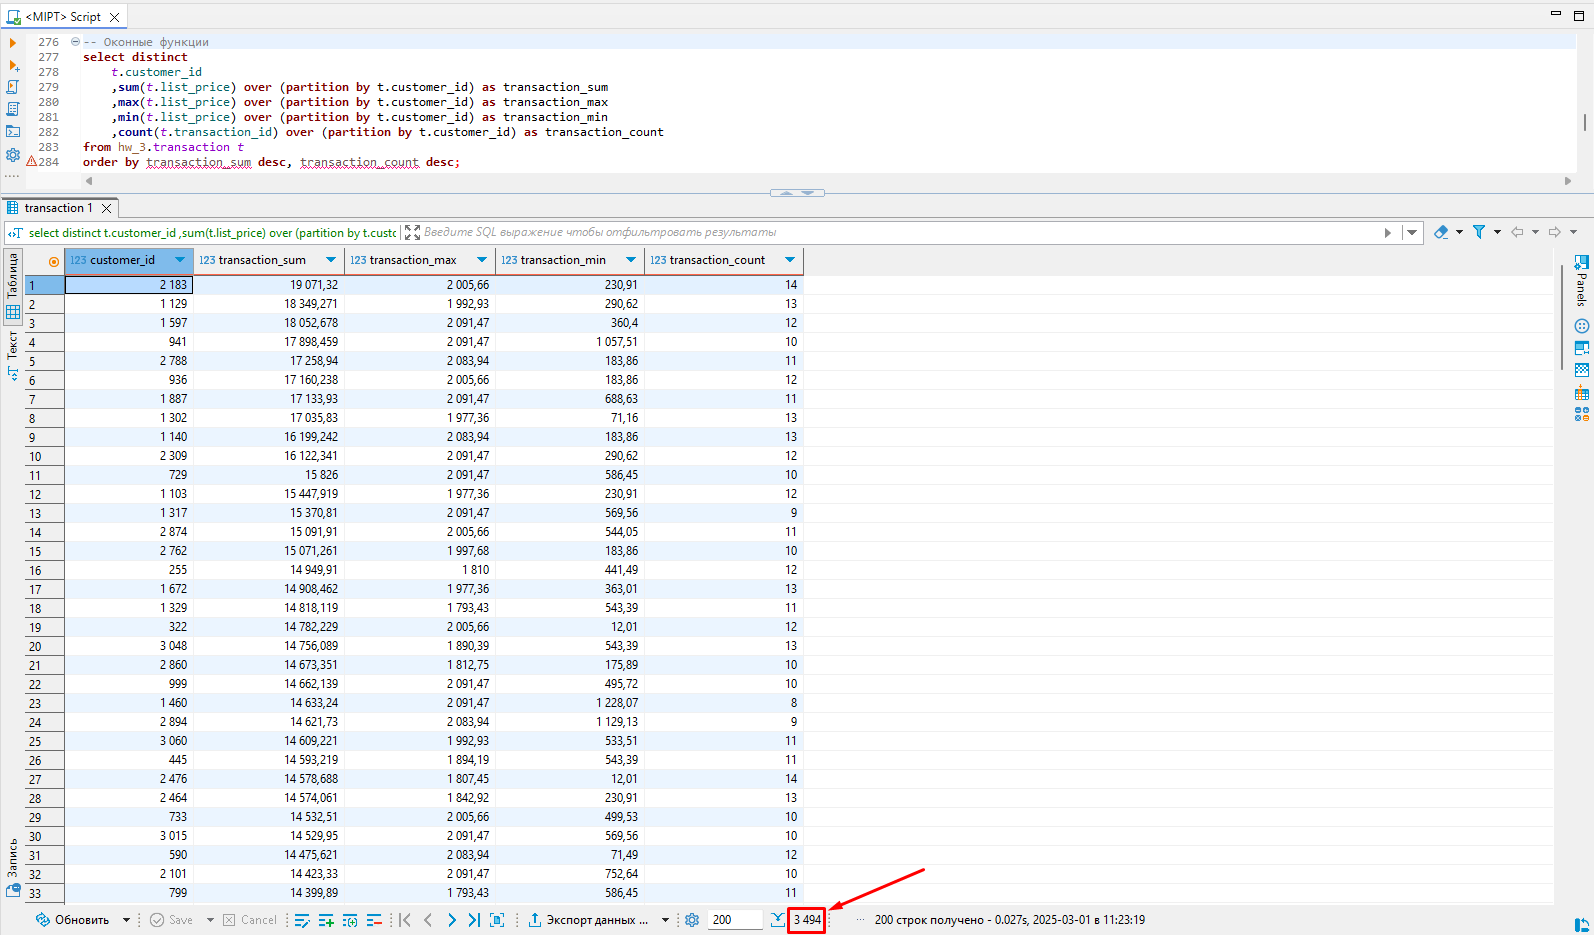

### 2.5. Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период (сумма транзакций не может быть null). Напишите отдельные запросы для минимальной и максимальной суммы ###
#### Скрипт ####
##### Минимальная сумма транзакций #####
<code>
with customer_transaction_sum as (
    select distinct
        t.customer_id
        ,sum(t.list_price) over (partition by t.customer_id) as transaction_sum
    from hw_3.transaction t
)
,min_transaction_sum as (
    select min(transaction_sum) as min_transaction_sum
    from customer_transaction_sum
)
select
    c.first_name
    ,c.last_name
    ,cts.transaction_sum
    ,mts.min_transaction_sum
from hw_3.customer c
join customer_transaction_sum cts on cts.customer_id = c.customer_id
join min_transaction_sum mts on mts.min_transaction_sum = cts.transaction_sum
order by c.first_name, c.last_name;
</code>

##### Максимальная сумма транзакций #####
<code>
with customer_transaction_sum as (
    select distinct
        t.customer_id
        ,sum(t.list_price) over (partition by t.customer_id) as transaction_sum
    from hw_3.transaction t
)
,max_transaction_sum as (
    select max(transaction_sum) as max_transaction_sum
    from customer_transaction_sum
)
select
    c.first_name
    ,c.last_name
    ,cts.transaction_sum
    ,mts.max_transaction_sum
from hw_3.customer c
join customer_transaction_sum cts on cts.customer_id = c.customer_id
join max_transaction_sum mts on mts.max_transaction_sum = cts.transaction_sum
order by c.first_name, c.last_name;
</code>

#### Результат выполнения ####
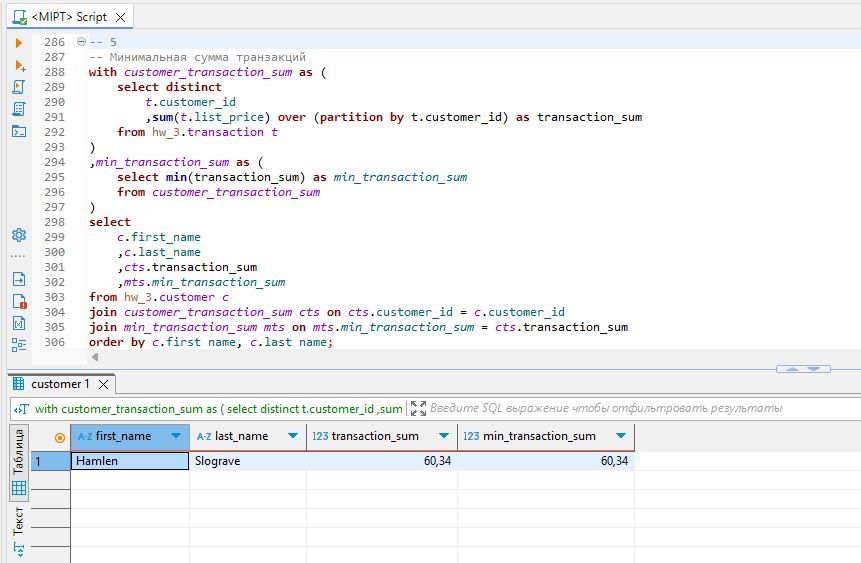
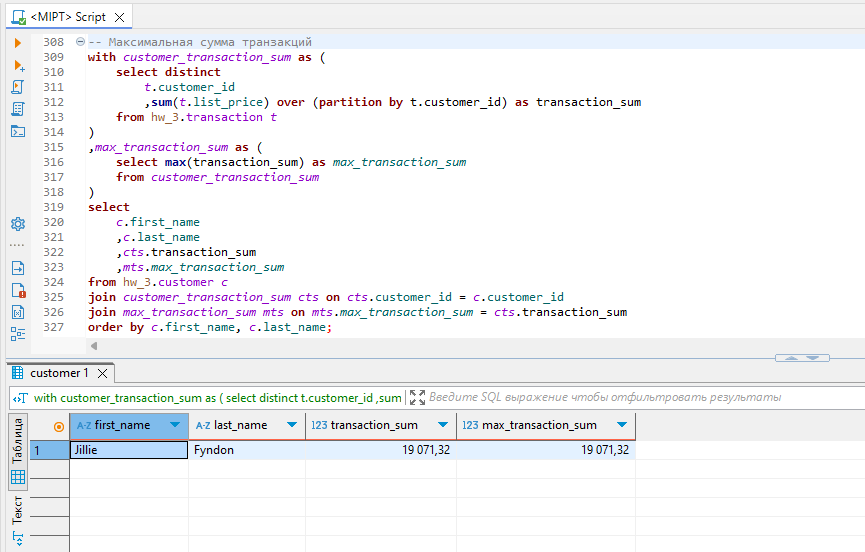

### 2.6. Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций ###
#### Скрипт ####
<code>
with customer_transaction as (
    select
        t.*
        ,row_number() over (partition by t.customer_id order by to_date(t.transaction_date, 'DD.MM.YYYY')) as rn
    from hw_3.transaction t
)
select *
from customer_transaction ct
where ct.rn = 1
order by ct.customer_id;
</code>

#### Результат выполнения ####
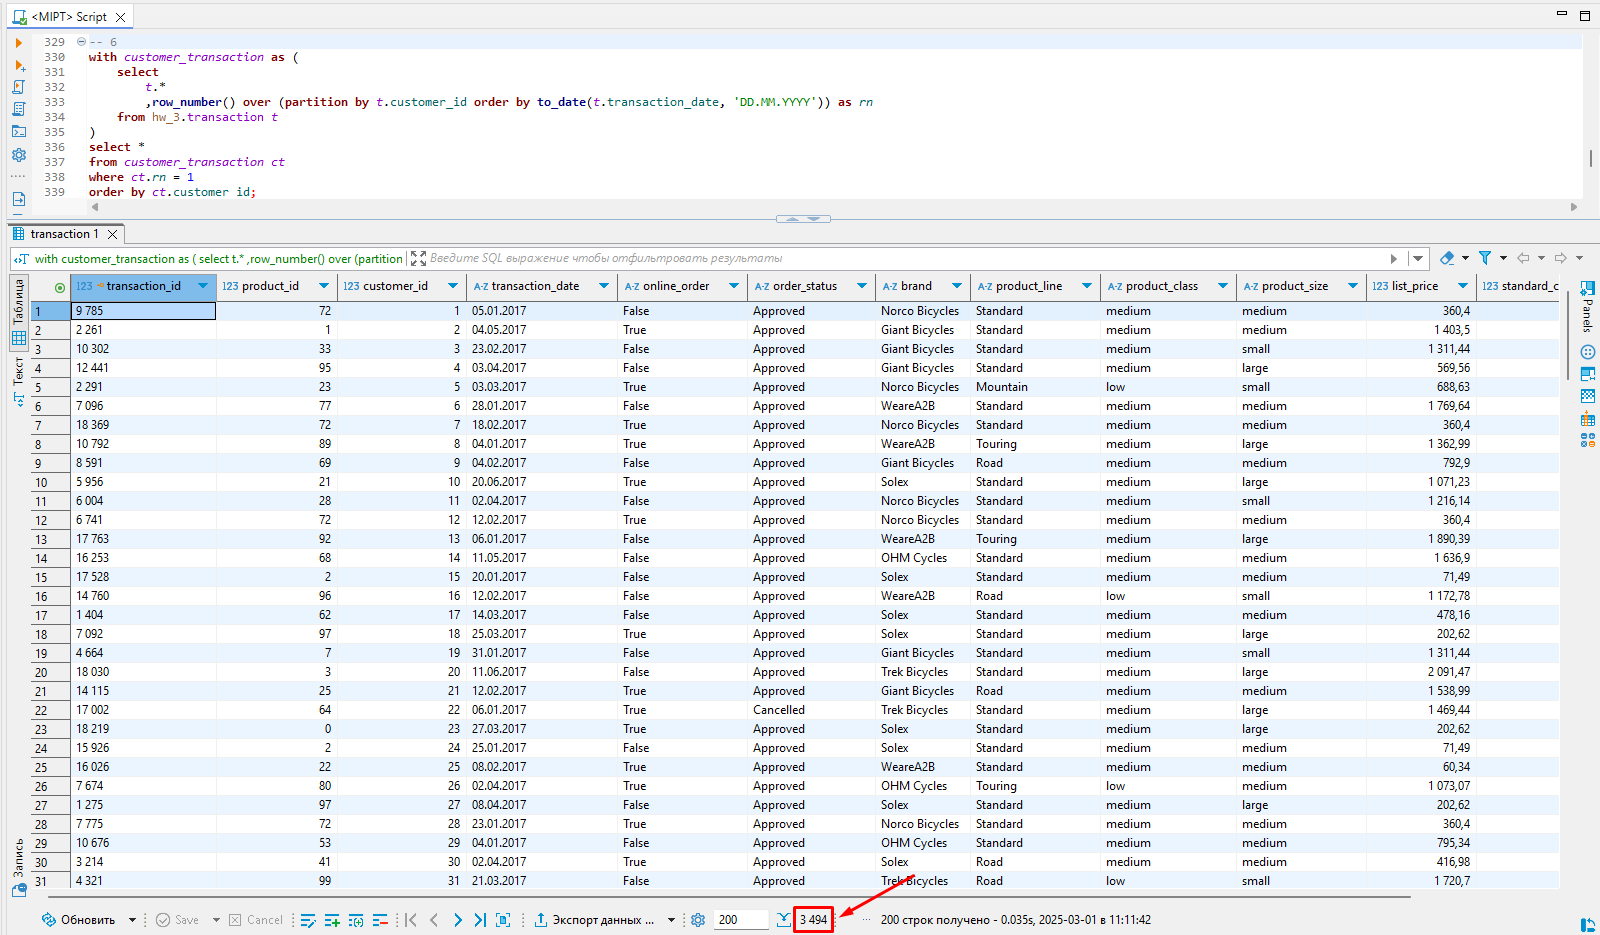

### 2.7. Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях) ###
#### Скрипт ####
<code>
with transaction_date as (
    select
        t.customer_id
        ,c.first_name
        ,c.last_name
        ,c.job_title
        ,to_date(t.transaction_date, 'DD.MM.YYYY') as transaction_date
    from hw_3.transaction t
    join hw_3.customer c on c.customer_id = t.customer_id
)
,lagged_date as (
    select
        td.customer_id
        ,td.first_name
        ,td.last_name
        ,td.job_title
        ,td.transaction_date
        ,lag(td.transaction_date) over (partition by td.customer_id order by td.transaction_date) as prev_transaction_date
    from transaction_date td
)
,date_difference as (
    select
        ld.customer_id
        ,ld.first_name
        ,ld.last_name
        ,ld.job_title
        ,ld.transaction_date
        ,ld.prev_transaction_date
        ,(ld.transaction_date - ld.prev_transaction_date) AS day_difference
    from lagged_date ld
    where ld.prev_transaction_date is not null
)
,max_difference as (
    select
        max(dd.day_difference) as max_day_difference
    from date_difference dd
)
select distinct
    dd.first_name
    ,dd.last_name
    ,dd.job_title
    ,dd.day_difference
    ,md.max_day_difference
from date_difference dd
join max_difference md on md.max_day_difference = dd.day_difference
order by dd.first_name, dd.last_name;
</code>

#### Результат выполнения ####
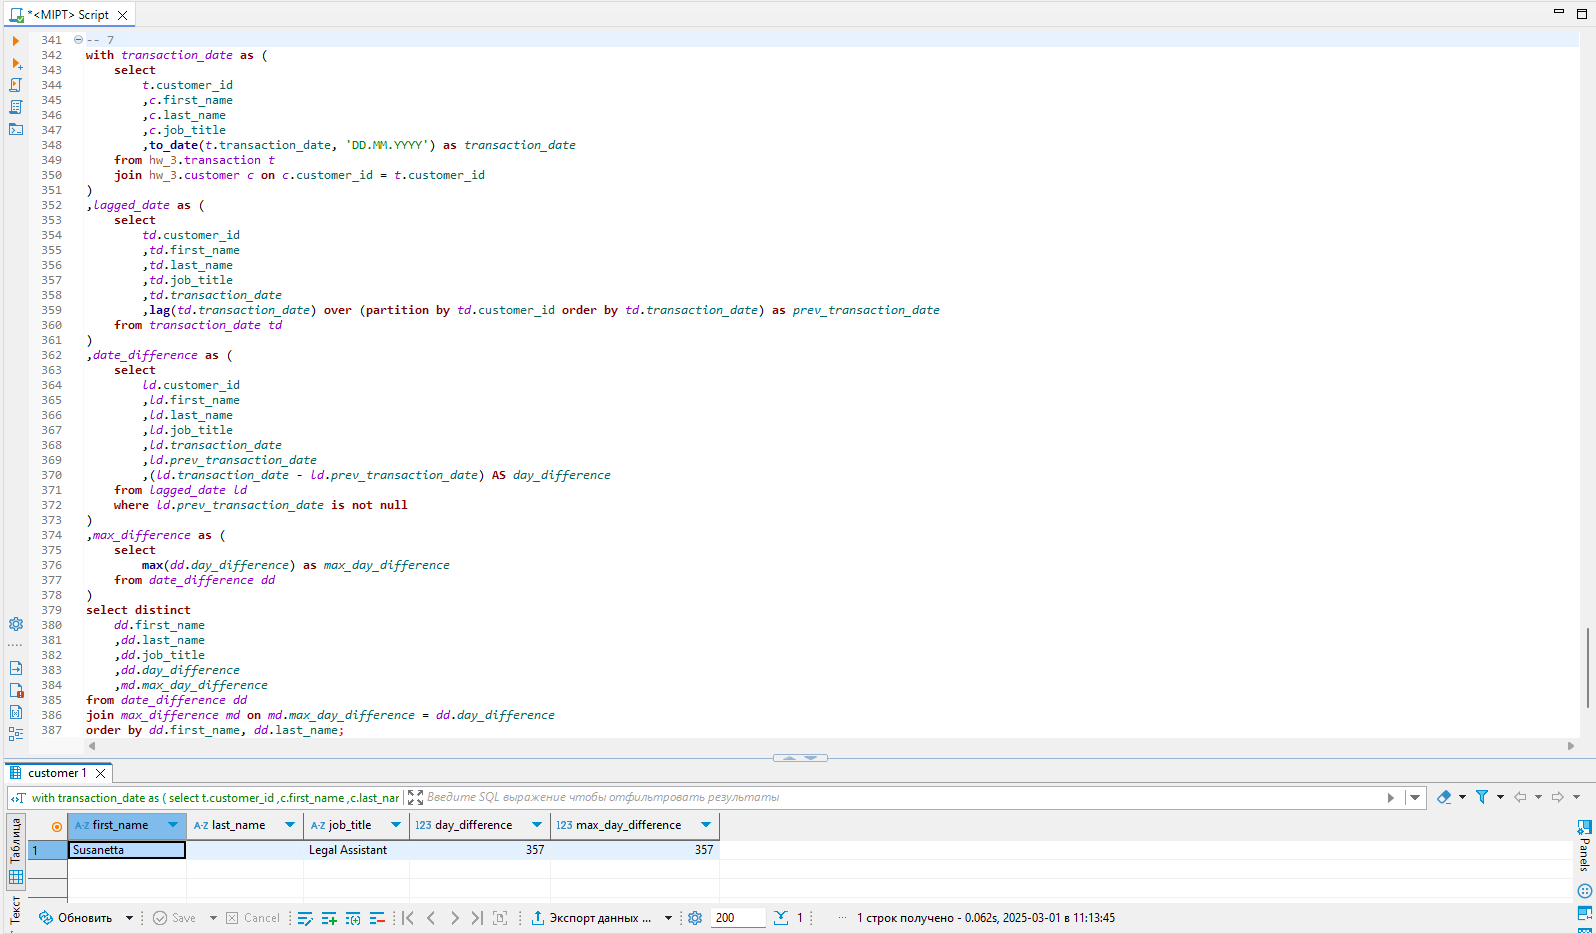